# Team Information

Project Title: Data Analysis on the Pokémon Pokedex

Team Name: Team 6

Member Names w/ PIDs: Rohan Jaggannagari (rjaggannagari), Jayanth Kalidindi (jayk21), Luke Hylton (lnhylton), Markus Homann (homann), Aniket Sonnakul (anikets)

# Contributions

Rohan Jaggannagari: Cleaned up and merged the datasets from Kaggle, PCA analysis/clustering/distance matrix on legendary Pokemon, correlation matrix for each base stat and generation, recomendation system

Jayanth Kalidindi: Helped clean up and merge datasets and write/build recommendation system with sliders. 

Luke Hylton: Wrote code and implemented weighted sliders section.

Markus Homann: Worked on the report, analysis of Legendary data with respect to similarity between one another, and worked on the PCA analysis/ Clustering 

Aniket Sonnakul: Helped clean dataset and analyze categorical data, and consolidate/write QAC descriptions on report.

# Using Data Science to Analyze Pokemon Data

To answer this question, first we need to define the data collected. The primary dataset consists of each pokemon 'from' Generations '1-7' 'with' their characteristics.

The different characteristics of Pokemon that we are going to be looking at are: Name, Type1,Type2, Hp, Attack, Defense, Special Attack, Special Defense, Speed, Against Poison, Against Psychic, Against Rock, Against Steel, Against Water, Capture Rate, Experience Growth, Height (M), Percentage Male, Weight (Kg). 

The additional dataset shows each Pokemon’s abilities and how their types match up against other types. 


First we import several modules that will be used to extract, clean, and visualize the data, and then read in the datasets:

# Research Questions

## How can we use data science to analyze Pokemon data?
    1. What Pokemon have the most similar statistics?
    2. How do legendary Pokemon cluster depending on the number of clusters?
    3. How can we see which types correlate with which attributes?
    4. How do different statistics correlate over different generations?
    5. Which Legendary Pokemon are most similar to each other?

## Imports

In [1]:
import pandas
import numpy
import IPython
import sklearn.metrics.pairwise
import sklearn.cluster
import sklearn.decomposition
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from IPython.display import display, clear_output

## Reading in data

In [2]:
# Read in the data
pokemon_data_df = pandas.read_csv('pokemon_data.csv')
pokemon_abilities_df = pandas.read_csv('pokemon_abilities.csv')

# Output the shape of the data
print("Shape of first dataset is " + str(pokemon_data_df.shape))
print("Shape of second dataset is " + str(pokemon_abilities_df.shape))

Shape of first dataset is (800, 12)
Shape of second dataset is (801, 41)


The data sets are cleaned for specific cases and then merged into a single dataframe.

## Merge both datasets and then clean them

In [3]:
# Some Pokemon in each dataset were named differently so I fixed it
pokemon_data_df.loc[pokemon_data_df['Name'] == 'Ho-oh', 'Name'] = 'Ho-Oh'
pokemon_data_df.loc[pokemon_data_df['Name'] == 'Landorus Therian Forme', 'Name'] = 'Landorus'
pokemon_data_df.loc[pokemon_data_df['Name'] == 'Tornadus Therian Forme', 'Name'] = 'Tornadus'
pokemon_data_df.loc[pokemon_data_df['Name'] == 'Thundurus Therian Forme', 'Name'] = 'Thundurus'
pokemon_data_df.loc[pokemon_data_df['Name'] == 'Hoopa Confined', 'Name'] = 'Hoopa'

# Move the name column to all the way to the left
if "name" in pokemon_abilities_df.columns:
    move_name = pokemon_abilities_df.pop('name')
    pokemon_abilities_df.insert(0, 'Name', move_name)

# Merged the two datasets and now have to clean it up so it is more readable
pokemon_df = pandas.merge(pokemon_data_df, pokemon_abilities_df, on = 'Name', how = 'inner', indicator = True)
pokemon_df = pokemon_df[pokemon_df['_merge'] == 'both']

# We do not care about megas so the data from the second dataset number is better to index by
move_pokedex_number = pokemon_df.pop('pokedex_number')
pokemon_df.insert(0, 'Pokedex Number', move_pokedex_number)

# Gets rid of the columns we are not using and the duplicates
pokemon_df = pokemon_df.drop(['#', 'attack', 'base_egg_steps', 'base_happiness', 'base_total', 'classfication', 'defense', 'hp', 'japanese_name', 'sp_attack','sp_defense','speed','type1','type2','generation','is_legendary', '_merge'], axis = 1)

# Format the names to be more uniform
pokemon_df.columns = [underscore_rem.replace('_', ' ') for underscore_rem in pokemon_df.columns]
pokemon_df.columns = [caps.title() for caps in pokemon_df.columns]

pokemon_df.head(5)

,Pokedex Number,Name,Type 1,Type 2,Hp,Attack,Defense,Sp. Atk,Sp. Def,Speed,...,Against Poison,Against Psychic,Against Rock,Against Steel,Against Water,Capture Rate,Experience Growth,Height M,Percentage Male,Weight Kg
0,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,...,1.0,2.0,1.0,1.0,0.5,45,1059860,0.7,88.1,6.9
1,2,Ivysaur,Grass,Poison,60,62,63,80,80,60,...,1.0,2.0,1.0,1.0,0.5,45,1059860,1.0,88.1,13.0
2,3,Venusaur,Grass,Poison,80,82,83,100,100,80,...,1.0,2.0,1.0,1.0,0.5,45,1059860,2.0,88.1,100.0
3,4,Charmander,Fire,NaN,39,52,43,60,50,65,...,1.0,1.0,2.0,0.5,2.0,45,1059860,0.6,88.1,8.5
4,5,Charmeleon,Fire,NaN,58,64,58,80,65,80,...,1.0,1.0,2.0,0.5,2.0,45,1059860,1.1,88.1,19.0


Above, we merged the two datasets and cleaned them so they are uniform. This will make it easier to analyze the data since it is readable. We ouput the first 5 from the dataframe to show how to looks.

# What Pokemon have the most similar statistics?

We want to find a Pokemon that has a high stat in a category that is lacking in the current lineup. This is also useful for if we want to find a similar Pokemon to one in our squad but of a different type. For example, let's say you wanted to replace a Pokemon on your team with one that is faster but the other stats remain the same. This recomendation system makes that easy, since you will be provided a list of Pokemon. The second recomendation system is used to weight specfic stats kind of like the Andromeda we worked with in class. 

## Similarity Sliders

Each slider has a minimum value of 1 and a maximum value of 99 that can be chosen by the user. With the desired traits at their values, the recommendation system will rank Pokemons that are closest to the user’s inputs. We can hypothesize that the Pokemon which are ranked as most similar together will be closer together on a 2D visualization.

In [39]:
# Making the sliders for each stat
generation_slider = widgets.IntSlider(value = 1, min = 1, max = 7, step = 1, description = 'Generation:', description_width = 'auto')
generation_slider.layout.width = '75%'
hp_slider = widgets.IntSlider(value = 1, min = 1, max = 99, step = 1, description = 'HP:', description_width = 'auto')
hp_slider.layout.width = '75%'
attack_slider = widgets.IntSlider(value = 1, min = 1, max = 99, step = 1, description = 'Attack:', description_width = 'auto')
attack_slider.layout.width = '75%'
defense_slider = widgets.IntSlider(value = 1, min = 1, max = 99, step = 1, description = 'Defense:', description_width = 'auto')
defense_slider.layout.width = '75%'
sp_attack_slider = widgets.IntSlider(value = 1, min = 1, max = 99, step = 1, description = 'Sp. Attack:', description_width = 'auto')
sp_attack_slider.layout.width = '75%'
sp_defense_slider = widgets.IntSlider(value = 1, min = 1, max = 99, step = 1, description = 'Sp. Defense:', description_width = 'auto')
sp_defense_slider.layout.width = '75%'
speed_slider = widgets.IntSlider(value = 1, min = 1, max = 99, step = 1, description = 'Speed:', description_width = 'auto')
speed_slider.layout.width = '75%'

print("\n" + "Set the sliders to the desired amount and the code below will output Pokemon that are most similar" + "\n")
print("Note: These values are going to be used as %'s" + "\n" + "\n")
print("Choose a generation from 1 to 6, and choose 7 for all generations")
display(generation_slider, hp_slider, attack_slider, defense_slider, sp_attack_slider, sp_defense_slider, speed_slider)


Set the sliders to the desired amount and the code below will output Pokemon that are most similar

Note: These values are going to be used as %'s


Choose a generation from 1 to 6, and choose 7 for all generations


IntSlider(value=1, description='Generation:', layout=Layout(width='75%'), max=7, min=1)

IntSlider(value=1, description='HP:', layout=Layout(width='75%'), max=99, min=1)

IntSlider(value=1, description='Attack:', layout=Layout(width='75%'), max=99, min=1)

IntSlider(value=1, description='Defense:', layout=Layout(width='75%'), max=99, min=1)

IntSlider(value=1, description='Sp. Attack:', layout=Layout(width='75%'), max=99, min=1)

IntSlider(value=1, description='Sp. Defense:', layout=Layout(width='75%'), max=99, min=1)

IntSlider(value=1, description='Speed:', layout=Layout(width='75%'), max=99, min=1)

The slider will be used to show what you want the specfic stats at.

## Similarity Recomendation System

In [41]:
# Only account for the stats
pokemon_rec = pokemon_df[['Name', 'Hp', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed', 'Generation']]
pokemon_rec = pokemon_rec.set_index('Name')

if generation_slider.value != 7:
    pokemon_rec = pokemon_rec[pokemon_rec['Generation'] == generation_slider.value]
pokemon_rec = pokemon_rec.drop(['Generation'], axis=1)

# Get all of the maxes for all the stats
hp_max = pokemon_rec['Hp'].max()
attack_max = pokemon_rec['Attack'].max()
defense_max = pokemon_rec['Defense'].max()
sp_attack_max = pokemon_rec['Sp. Atk'].max()
sp_defense_max = pokemon_rec['Sp. Def'].max()
speed_max = pokemon_rec['Speed'].max()

# Based on the slider
hp_value = (hp_slider.value * (hp_max - 1))/100
attack_value = (attack_slider.value * (attack_max - 5))/100
defense_value = (defense_slider.value * (defense_max - 5))/100
sp_attack_value = (sp_attack_slider.value * (sp_attack_max - 10))/100
sp_defense_value = (sp_defense_slider.value * (sp_defense_max - 20))/100
speed_value = (speed_slider.value * (speed_max - 5))/100

# Uses the inputs to find most similar
inputs = numpy.array([hp_value, attack_value, defense_value, sp_attack_value, sp_defense_value, speed_value]).reshape(1, -1)
euc_dist = sklearn.metrics.pairwise.euclidean_distances(pokemon_rec.values, inputs)

# Sorts the dataframe
euc_dist_df = pandas.DataFrame(euc_dist, index = pokemon_rec.index, columns = ['Distance'])
euc_dist_df = euc_dist_df.sort_values('Distance')

rankings = pandas.DataFrame(euc_dist_df.index)
rankings_with_stats = pandas.merge(rankings, pokemon_rec, on = 'Name', how = 'inner')
rankings_with_stats.index.name = "Rankings"
rankings_with_stats.head(15)

,Name,Hp,Attack,Defense,Sp. Atk,Sp. Def,Speed
Rankings,,,,,,,
0,Hariyama,144,120,60,40,60,50
1,Wailord,170,90,45,90,45,60
2,Wobbuffet,190,33,58,33,58,33
3,Alomomola,165,75,80,40,45,65
4,Munchlax,135,85,40,40,85,5
5,Snorlax,160,110,65,65,110,30
6,Wailmer,130,70,35,70,35,60
7,Wigglytuff,140,70,45,85,50,45
8,Jigglypuff,115,45,20,45,25,20


Above, you will be provided a dataframe that finds the closest to what the sliders were set to.

With the recommendation system, I can for example take my Pokemon Weedle which has a HP of 40 and speed of 50. I want to find another Pokemon that is of similar HP, but a higher speed. By setting my desired sliders in the recommendation system I see that Smeargle is a similar Pokemon with an HP of 55 and speed of 75, which meets my desired requirements. There are many other applications for this recommendation system as it allows us to find Pokemon based on specific traits that we are looking for with rankings. 

## Ability Weights Recomendation System

Note: We used the Andromeda instructor notes to build this system

### Gather columns and clean data for weighting

In [6]:
pokemon_weights_rec = pokemon_df[['Hp', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']]
pokemon_weights_rec = pokemon_weights_rec.set_index(pokemon_df.Name)
pokemon_weights_rec = pokemon_weights_rec.fillna(0).astype("int64")
normalized_pokemon = (pokemon_weights_rec - pokemon_weights_rec.mean()) / pokemon_weights_rec.std()

### Weight the data according the weights recieved in function

We are going to weight the data from 0.00001 to 0.9999. 

In [7]:
def weight_data(dataHD, wts):
    # Normalize the weights to sum to 1
    wts = wts / wts.sum()
    
    # Apply weights to the HD data 
    dataHDw = pandas.DataFrame(dataHD * wts)

    # Compute row relevances as:  data dot weights
    # High relevance means large values in upweighted dimensions
    dataHDw['relevance'] = dataHDw.sum(axis=1)
    return dataHDw

min_weight, max_weight = 0.00001, 0.9999
init_weight = min_weight
weights = pandas.Series(init_weight, index=normalized_pokemon.columns, name = "Weight")

df_2D = weight_data(normalized_pokemon, weights)

### Create sliders for weighing data according to users preferences

This creates the sliders that are used below.

In [8]:
def create_sliders(wts):
    # Create sliders, one for each dimension weight
    sliders = [widgets.FloatSlider(min = min_weight, max = max_weight, step = 0.01, value = value, 
                                       description = label, continuous_update = False, readout_format = '.5f')
                   for (label, value) in wts.iteritems()]
    
    # Make the sliders larger
    for slider in sliders:
        slider.layout.width = '75%'
        
    # Display sliders
    for s in sliders:
        display(s)
        
    create_slider_buttons(sliders)
    return sliders

# Makes the buttons to reset and apply
def create_slider_buttons(sliders):    
    apply_button = widgets.Button(description = 'Apply Slider Weights')
    reset_button = widgets.Button(description =' Reset Weights')
    
    output = widgets.Output()
    with output:
        display()

    # More functions
    def apply_button_clicked(change):
        global weights, df_2D
        weights = pandas.Series([s.value for s in sliders], index=normalized_pokemon.columns, name='Weight')
        df_2D = weight_data(normalized_pokemon, weights)
    
        display_data(df_2D)
    apply_button.on_click(apply_button_clicked)

    def reset_button_clicked(change):
        for s in sliders:
            s.value = init_weight
        apply_button_clicked(change)
    reset_button.on_click(reset_button_clicked)
    
    def display_data(data):
        data = data.sort_values("relevance", ascending = False)
        rankings = pandas.DataFrame(data.index)
        rankings_with_stats = pandas.merge(rankings, pokemon_weights_rec, on = 'Name', how = 'inner')
        rankings_with_stats.index.name = "Rankings"

        # Reoutput the rankings
        with output:
            output.clear_output()
            display(rankings_with_stats.head(10))
    
    # Display buttons
    display(apply_button)
    display(reset_button)
    display(output)
    return apply_button, reset_button

### Creates sliders

In [9]:
sliders = create_sliders(weights)

FloatSlider(value=1e-05, continuous_update=False, description='Hp', layout=Layout(width='75%'), max=0.9999, mi…

FloatSlider(value=1e-05, continuous_update=False, description='Attack', layout=Layout(width='75%'), max=0.9999…

FloatSlider(value=1e-05, continuous_update=False, description='Defense', layout=Layout(width='75%'), max=0.999…

FloatSlider(value=1e-05, continuous_update=False, description='Sp. Atk', layout=Layout(width='75%'), max=0.999…

FloatSlider(value=1e-05, continuous_update=False, description='Sp. Def', layout=Layout(width='75%'), max=0.999…

FloatSlider(value=1e-05, continuous_update=False, description='Speed', layout=Layout(width='75%'), max=0.9999,…

Button(description='Apply Slider Weights', style=ButtonStyle())

Button(description=' Reset Weights', style=ButtonStyle())

Output()

There is a difference between the other recomendation system and this recomendation system. This one weights the stats as the other one finds Pokemon based on all of the stats.

For example, if you wanted to find a Pokemon that only cares about Hp and Attack only increase those sliders. And then you will get a dataframe that only weights those stats. So if we set HP and attack to the max for unweighted sliders for all generations, the table will be different for the weighted sliders setting HP and attack to the 99th percentile. The number 1 Pokemon in both these cases will be Hariyama and Slaking for unweighted and weighted, respectively. The Hariyama has HP, attack, defense, sp. attack, sp. defense, and speed are at 144, 120, 60, 40, 60, and 50 respectively. Meanwhile the Slaking has stats of 150, 160, 100, 95, 65, and 100 in those categories. 

## How do legendary Pokemon cluster depending on the number of clusters?

This question looks into how legendary Pokemon cluster when there is a different amount of clusters.

You can choose the amount of clusters wanted.

In [10]:
# Makes a cluster slider
cluster_slider = widgets.IntSlider(value = 1, min = 1, max = 42, step = 1, description = 'Clusters:', description_width='auto')
cluster_slider.layout.width = '75%'
display(cluster_slider)

IntSlider(value=1, description='Clusters:', layout=Layout(width='75%'), max=42, min=1)

In [11]:
# Makes a copy of the data from above
legendary_df = pokemon_df.copy()

# Filters based on whether it is legendary or not
legendary_df = legendary_df[legendary_df['Legendary']]

# Only use columns with statistics
legendary_df = legendary_df.iloc[:, [1, 4, 5, 6, 7, 8, 9]]

# Get rid of the index and reset it to the name
legendary_df = legendary_df.reset_index()
legendary_df = legendary_df.drop(['index'], axis = 1)
legendary_df = legendary_df.set_index('Name')

# Normalize the data
legendary_df = (legendary_df - legendary_df.mean())/legendary_df.std()

# Clustering the data into a specfic amount of clusters
specfic_clusters = sklearn.cluster.KMeans(n_clusters = cluster_slider.value)
specfic_clusters.init = legendary_df.iloc[:cluster_slider.value,:]
cluster_df = specfic_clusters.fit_predict(legendary_df)

# Puts the data into a dataframe
clustered_legendary = pandas.DataFrame(cluster_df, columns = ['Cluster'], index = legendary_df.index)
clustered_legendary = clustered_legendary.sort_values('Cluster')

# Dataframe to show size per cluster
cluster_size = numpy.bincount(clustered_legendary['Cluster'])
cluster_total_df = pandas.DataFrame({'Size': cluster_size})
cluster_total_df = cluster_total_df.reset_index().rename(columns={'index': 'Cluster'})

cluster_total_df

C:\Users\anike\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
C:\Users\anike\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


,Cluster,Size
0,0,42


Now we know how big each cluster is and that lets us know the groupings.

<function matplotlib.pyplot.show(close=None, block=None)>

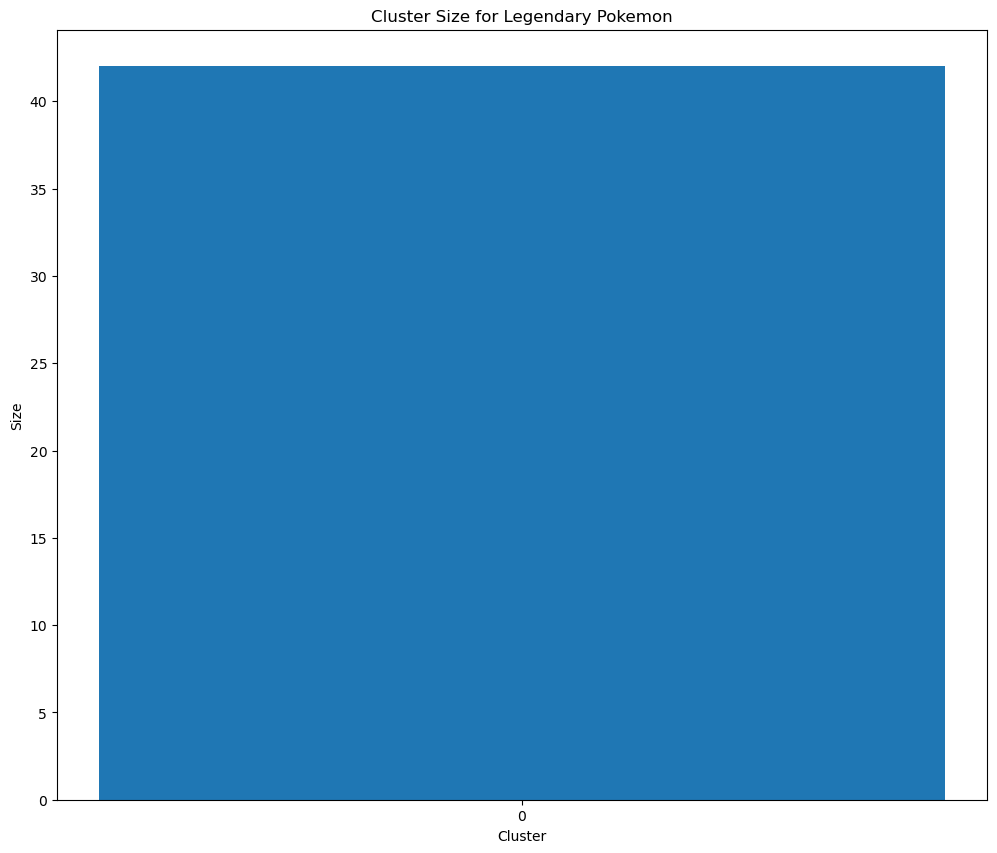

In [12]:
# Bar chart to show cluster size
fig, ax = plt.subplots(figsize=(12, 10))
plt.bar(cluster_total_df['Cluster'], cluster_total_df['Size'])
plt.xticks(cluster_total_df.index, cluster_total_df.index)
plt.xlabel('Cluster')
plt.ylabel('Size')
plt.title('Cluster Size for Legendary Pokemon')
plt.show

The graph is a way to see how different clusters have different amounts.

# How can we see which types correlate with which attributes?

We can't display a correlation matrix the same way for categorical vs numerical data, but we can see how the averages of a numerical column compare among the types.

In [13]:
corrTypes = pokemon_df.copy()
typeMean = pokemon_df.groupby('Type 1')['Attack'].mean()
typeMean.head(5)

Type 1
Bug          65.322581
Dark         86.250000
Dragon      102.739130
Electric     67.500000
Fairy        61.529412
Name: Attack, dtype: float64

In [14]:
corrTypes['Type 1'].unique()

array(['Grass', 'Fire', 'Water', 'Bug', 'Normal', 'Poison', 'Electric',
       'Ground', 'Fairy', 'Fighting', 'Psychic', 'Rock', 'Ghost', 'Ice',
       'Dragon', 'Dark', 'Steel', 'Flying'], dtype=object)

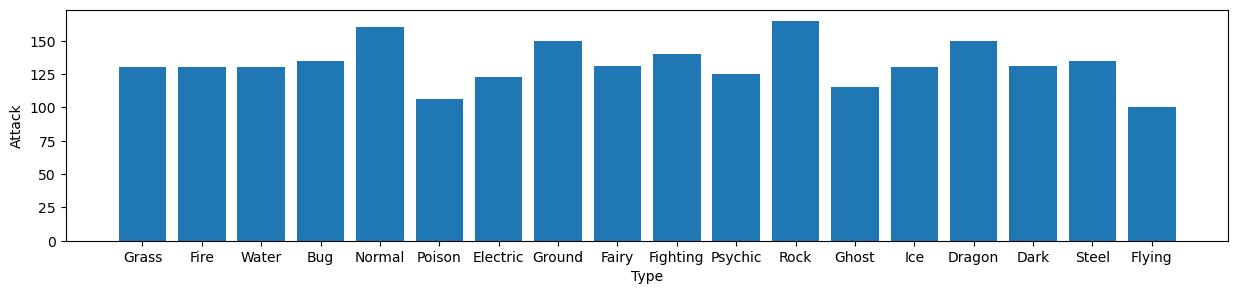

In [15]:
plt.figure(figsize = (15, 3))
plt.bar(corrTypes['Type 1'], corrTypes['Attack'])
plt.xlabel('Type')
plt.ylabel('Attack')
plt.show()

From the distribution, Normal and Rock types have the highest attack on average, while Poison and Flying have the least.

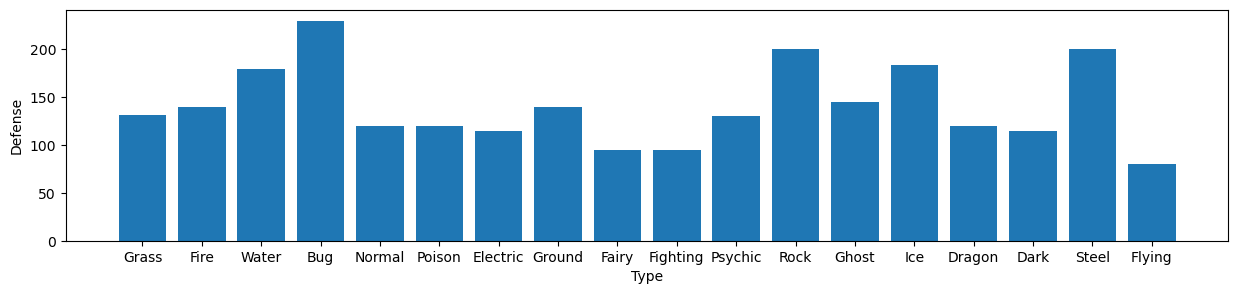

In [16]:
plt.figure(figsize=(15, 3))
plt.bar(corrTypes['Type 1'], corrTypes['Defense'])
plt.xlabel('Type')
plt.ylabel('Defense')
plt.show()

Bug, Rock, and Steel have the highest defense mean, while Flying, Fairy, and Fighting have the least.

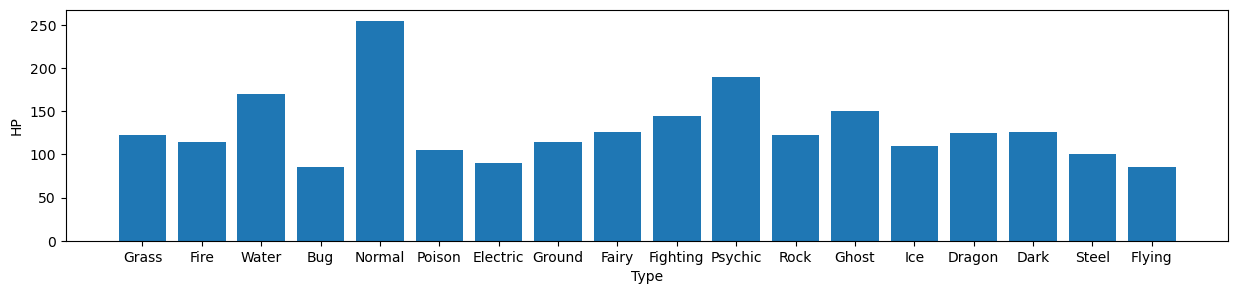

In [17]:
plt.figure(figsize = (15, 3))
plt.bar(corrTypes['Type 1'], corrTypes['Hp'])
plt.xlabel('Type')
plt.ylabel('HP')
plt.show()

For HP, Normal has the highest by a significant margin while Flying has the least. This distribution is much more varied than the others.

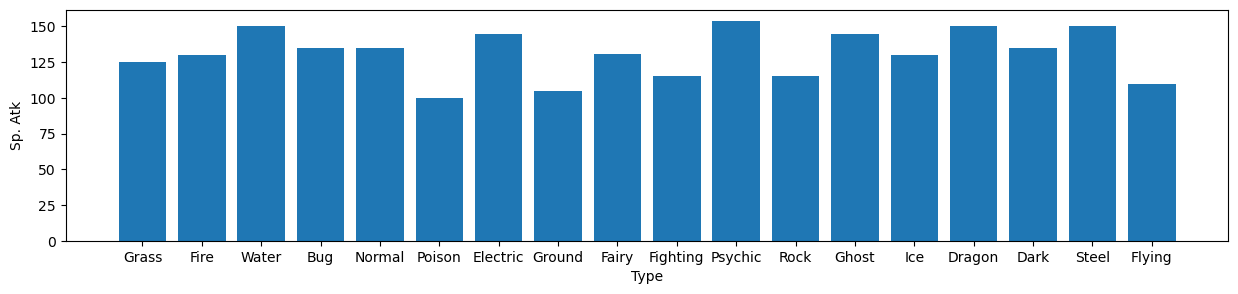

In [42]:
plt.figure(figsize = (15, 3))
plt.bar(corrTypes['Type 1'], corrTypes['Sp. Atk'])
plt.xlabel('Type')
plt.ylabel('Sp. Atk')
plt.show()

For Special Attack, Psychic is the highest though most of the types look to have an average around the same.

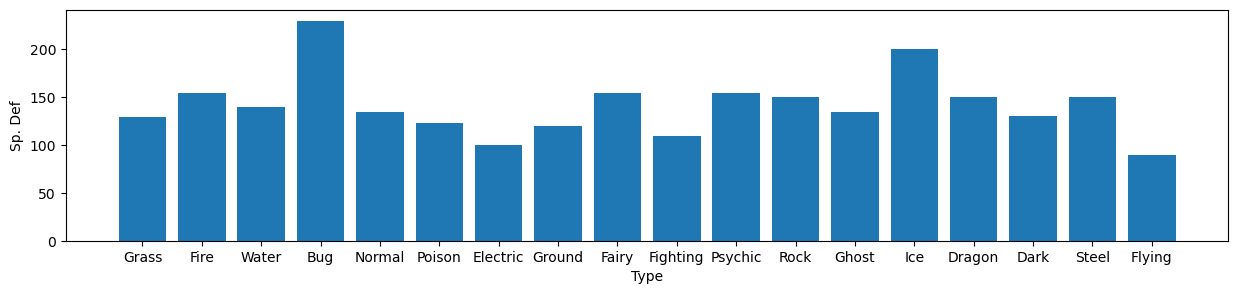

In [43]:
plt.figure(figsize = (15, 3))
plt.bar(corrTypes['Type 1'], corrTypes['Sp. Def'])
plt.xlabel('Type')
plt.ylabel('Sp. Def')
plt.show()

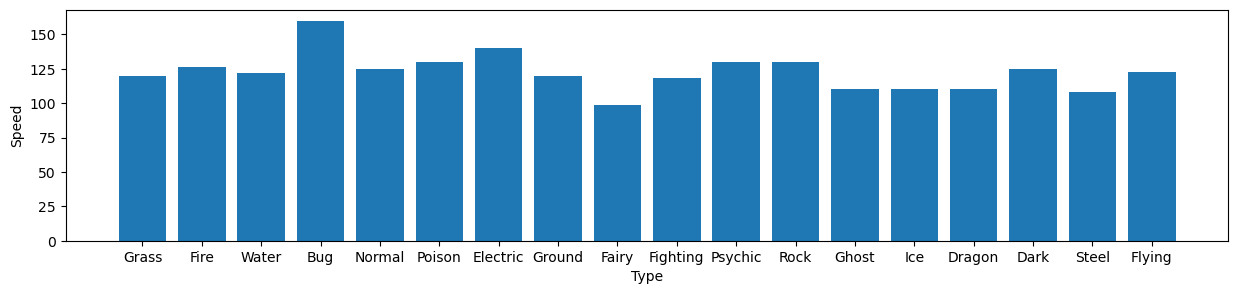

In [45]:
plt.figure(figsize = (15, 3))
plt.bar(corrTypes['Type 1'], corrTypes['Speed'])
plt.xlabel('Type')
plt.ylabel('Speed')
plt.show()

Since we are looking at averages in these distributions, the more significant the margin between stats for a type would likely correlate with that type having a higher stat level. So what we conclude perhaps the best is that you would have a good chance of having a high HP Pokemon with a Normal type. What we do not know however is if there are outliers skewing this data and bringing up the mean.

# How do different statistics correlate over different generations?


The slider below will allow for you to set it to a specfic generation to

In [ ]:
gen_slider = widgets.IntSlider(value = 1, min = 1, max = 7, step = 1, description = 'Generation:', description_width='auto')
gen_slider.layout.width = '75%'
print('\n' + 'Note: Choose 7 if you wany to see across generations 1-6')
display(gen_slider)

Below, we will look for correlations across different generations or all generations and output it. We have a specfic set of stats that we want to look at.

In [ ]:
# Create a copy to not mess up previous dataset
generation_df = pokemon_df.copy()

# Only allows Pokemon from that generation
if gen_slider.value != 7:
    generation_df = generation_df[generation_df['Generation'] == gen_slider.value]
generation_corr_stats = generation_df[['Name', 'Type 1', 'Type 2', 'Hp', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed', 'Height M', 'Percentage Male', 'Weight Kg']]
generation_corr_stats = generation_corr_stats.set_index('Name')

# Encode the string
encode_string = LabelEncoder()
generation_corr_stats['Type 1'] = encode_string.fit_transform(generation_corr_stats['Type 1'])
generation_corr_stats['Type 2'] = encode_string.fit_transform(generation_corr_stats['Type 2'])

# Find the correlation matrix
generation_corr_fin = generation_corr_stats.corr()

generation_corr_fin

Now, we have have a dataframe that shows how the stats correlate with each other and now we want to visualize it.

In [ ]:
# Graph it
plt.figure(figsize = (12, 10))

if gen_slider.value != 7:
    plt.title('Correlation between Pokemon from Generation ' + str(gen_slider.value), fontsize = 20, pad = 20)
else:
    plt.title('Correlation between Pokemon from Generation 1 - 6', fontsize = 20, pad = 20)
    
sns.heatmap(generation_corr_fin, annot = True, cmap = 'coolwarm', cbar_kws = {'label': 'Correlation'}, linewidths = 0.25, linecolor = 'black')
plt.show()

What we see is that in the first generation there was not much correlation with the stats, but over more generations that started to change. The stats started to have more and more correlation. So overall, the first few generations did not have much correlation, but the last few had a lot more. For example, in generation 6 there was a strong correlation between height and weight with a value of 0.78. However, in generation 1 the value was only 0.59.

In conclusion, there is correlations between height and weight, special attack and special defense, special defense and defense, weight and attack, and weight and defense.

# Which Legendary Pokemon are most similar to each other?

In [46]:
norm = (legendary_df - legendary_df.mean())/ legendary_df.std()
euc_dist_matrix = sklearn.metrics.pairwise.euclidean_distances(norm)
euc_dist_matrix = pandas.DataFrame(euc_dist_matrix, index = legendary_df.index, columns = legendary_df.index)

numpy.fill_diagonal(euc_dist_matrix.values, numpy.NaN)

Now what if we want to find a pokemon most similar to a specific pokemon? We can use the distance matrix that we computed before to see which pokemon are closest together in. 

In [47]:
similar = pandas.DataFrame(euc_dist_matrix.idxmin())
similar = similar.rename(columns={0: "Most Similar To"})
similar.head(5)

,Most Similar To
Name,
Articuno,Suicune
Zapdos,Moltres
Moltres,Zapdos
Mewtwo,Palkia
Raikou,Latios


As we can see, we have found the most similar pokemon for each legendary displayed in the table. We can use this information to find a similar legendary pokemon when trading or swapping out during battle.

In conclusion, we were able to use a normalized euclidean distance matrix to find most similar pokemon in regards to the five stats we have been working with.

In [48]:
pokemon_df.head(10)

,Pokedex Number,Name,Type 1,Type 2,Hp,Attack,Defense,Sp. Atk,Sp. Def,Speed,...,Against Poison,Against Psychic,Against Rock,Against Steel,Against Water,Capture Rate,Experience Growth,Height M,Percentage Male,Weight Kg
0,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,...,1.0,2.0,1.0,1.0,0.5,45,1059860,0.7,88.1,6.9
1,2,Ivysaur,Grass,Poison,60,62,63,80,80,60,...,1.0,2.0,1.0,1.0,0.5,45,1059860,1.0,88.1,13.0
2,3,Venusaur,Grass,Poison,80,82,83,100,100,80,...,1.0,2.0,1.0,1.0,0.5,45,1059860,2.0,88.1,100.0
3,4,Charmander,Fire,NaN,39,52,43,60,50,65,...,1.0,1.0,2.0,0.5,2.0,45,1059860,0.6,88.1,8.5
4,5,Charmeleon,Fire,NaN,58,64,58,80,65,80,...,1.0,1.0,2.0,0.5,2.0,45,1059860,1.1,88.1,19.0
5,6,Charizard,Fire,Flying,78,84,78,109,85,100,...,1.0,1.0,4.0,0.5,2.0,45,1059860,1.7,88.1,90.5
6,7,Squirtle,Water,NaN,44,48,65,50,64,43,...,1.0,1.0,1.0,0.5,0.5,45,1059860,0.5,88.1,9.0
7,8,Wartortle,Water,NaN,59,63,80,65,80,58,...,1.0,1.0,1.0,0.5,0.5,45,1059860,1.0,88.1,22.5
8,9,Blastoise,Water,NaN,79,83,100,85,105,78,...,1.0,1.0,1.0,0.5,0.5,45,1059860,1.6,88.1,85.5
9,10,Caterpie,Bug,NaN,45,30,35,20,20,45,...,1.0,1.0,2.0,1.0,1.0,255,1000000,0.3,50.0,2.9


Here we have to edit the type matchup data so the multipliers are more intuitive .

In [49]:
multi = pokemon_df.copy()
filterCols = [col for col in pokemon_df.columns if col.startswith('Against')]
multi.loc[:, filterCols] = pokemon_df.loc[:, filterCols].apply(lambda x: 1 / x)
# replace infinite values with 0
multi = multi.replace(numpy.inf, 0.0)
multi

,Pokedex Number,Name,Type 1,Type 2,Hp,Attack,Defense,Sp. Atk,Sp. Def,Speed,...,Against Poison,Against Psychic,Against Rock,Against Steel,Against Water,Capture Rate,Experience Growth,Height M,Percentage Male,Weight Kg
0,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,...,1.0,0.5,1.0,1.00,2.0,45,1059860,0.7,88.1,6.9
1,2,Ivysaur,Grass,Poison,60,62,63,80,80,60,...,1.0,0.5,1.0,1.00,2.0,45,1059860,1.0,88.1,13.0
2,3,Venusaur,Grass,Poison,80,82,83,100,100,80,...,1.0,0.5,1.0,1.00,2.0,45,1059860,2.0,88.1,100.0
3,4,Charmander,Fire,NaN,39,52,43,60,50,65,...,1.0,1.0,0.5,2.00,0.5,45,1059860,0.6,88.1,8.5
4,5,Charmeleon,Fire,NaN,58,64,58,80,65,80,...,1.0,1.0,0.5,2.00,0.5,45,1059860,1.1,88.1,19.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
703,716,Xerneas,Fairy,NaN,126,131,95,131,98,99,...,0.5,1.0,1.0,0.50,1.0,45,1250000,3.0,NaN,215.0
704,717,Yveltal,Dark,Flying,126,131,95,131,98,99,...,1.0,0.0,0.5,1.00,1.0,45,1250000,5.8,NaN,203.0
705,719,Diancie,Rock,Fairy,50,100,150,100,150,50,...,1.0,1.0,1.0,0.25,0.5,3,1250000,0.7,NaN,8.8
706,720,Hoopa,Psychic,Ghost,80,110,60,150,130,70,...,2.0,2.0,1.0,1.00,1.0,3,1250000,NaN,NaN,NaN


# PCA on Legendary Pokemon with Clustering

What if we wanted to determine which pokemon are most similar to each other?

For this part we are going to do some dimension reduction on the data using PCA. We can hypothesize that points that are closer together on the PCA are more similar in terms of their stats. We can also see if the plotted points are more linear or non-linear, which tells you if the variables within the data are highly correlated or there may be more complex relationships between the variables.

The first step is to do PCA on the the legendary dataset

In [23]:
# Now lets find the location of each legendary Pokemon
pca = sklearn.decomposition.PCA(n_components = 2, svd_solver = 'full')
pca_model_data = pca.fit_transform(legendary_df)
pca_df = pandas.DataFrame(pca_model_data, index = legendary_df.index, columns = ['X', 'Y'])
pca_df = pca_df.sort_index()
pca_df = pca_df.reset_index()

pca_df.head(5)

,Name,X,Y
0,Arceus,-1.062206,0.940334
1,Articuno,1.148798,-0.438500
2,Azelf,-1.664932,-0.792345
3,Cobalion,0.207121,0.647172
4,Darkrai,-0.758820,-1.685392


Next, we will decide the amount of clusters.

In [24]:
# Makes a cluster slider
cluster_slider = widgets.IntSlider(value = 1, min = 1, max = 42, step = 1, description = 'Clusters:', description_width='auto')
cluster_slider.layout.width = '75%'
display(cluster_slider)

IntSlider(value=1, description='Clusters:', layout=Layout(width='75%'), max=42, min=1)

Next, we will conduct Kmeans clustering to obtain our clusters.

In [50]:
kmeans = sklearn.cluster.KMeans(n_clusters = cluster_slider.value, n_init = 1, max_iter=10)
labels = kmeans.fit_predict(legendary_df)
labels_DataFrame = pandas.DataFrame(labels, index=legendary_df.index, columns=['Cluster']).sort_values('Cluster')
legendary_df_w_clusters = legendary_df.join(labels_DataFrame).sort_values('Cluster')
legendary_df_w_clusters

,Hp,Attack,Defense,Sp. Atk,Sp. Def,Speed,Cluster
Name,,,,,,,
Articuno,-0.201465,-0.936662,-0.101975,-0.731643,0.608827,-0.462124,0
Latios,-0.823638,-0.729828,-0.866785,0.624619,0.048065,0.808112,0
Latias,-0.823638,-1.143496,-0.484380,-0.150388,0.795748,0.808112,0
Darkrai,-1.445810,-0.729828,-0.484380,0.818370,-0.699617,1.570254,0
Lugia,0.794011,-0.729828,1.045240,-0.925395,1.692967,0.808112,0
Suicune,0.420707,-1.350330,0.471633,-0.925395,0.234986,-0.462124,0
Uxie,-1.134724,-1.350330,1.045240,-1.506650,0.795748,0.045970,0
Raikou,-0.201465,-0.936662,-1.057987,0.043363,-0.325776,1.062160,0
Virizion,-0.139248,-0.729828,-1.172709,-0.925395,0.758364,0.706493,0


Now, we will determine the size and max distance of each cluster to aid us in rendering our visualization.

In [51]:
clusters = sorted(list(set(labels)))
sizes = []
max_distances = []
for i in clusters:
    cur_cluster = legendary_df.join(labels_DataFrame)
    cur_cluster = cur_cluster[ cur_cluster['Cluster'] == i ]
    cur_cluster.iloc[:, :-1]
    sizes.append(cur_cluster.shape[0])
    max_distances.append(sklearn.metrics.pairwise.euclidean_distances(cur_cluster.iloc[:, :-1]).max())
    
clusters_df = pandas.DataFrame({'Cluster': clusters, 'Size': sizes, 'MaxDistance': max_distances})
clusters_df

,Cluster,Size,MaxDistance
0,0,9,4.086878
1,1,5,3.217809
2,2,7,2.846254
3,3,7,3.185770
4,4,4,6.052362
5,5,5,2.819559
6,6,5,2.821169


Now, we will obtain the x and y coordinates for each cluster.

In [52]:
tablePCA = pca.transform(kmeans.cluster_centers_)
tablePCA = pandas.DataFrame(tablePCA)
tablePCA.columns = ['X', 'Y']
tablePCA

C:\Users\anike\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


,X,Y
0,0.518097,-0.826069
1,-0.506111,1.428994
2,-0.053242,-0.677445
3,-0.602165,0.129424
4,3.834576,0.360513
5,-1.682140,0.922091
6,-0.894415,-0.385341


Next, we are ready display our pokemon in 2D with clusters, which aim to capture subgroups within the dataset.

Text(0.5, 1.0, 'PCA Dimension Reduction to show Similarity')

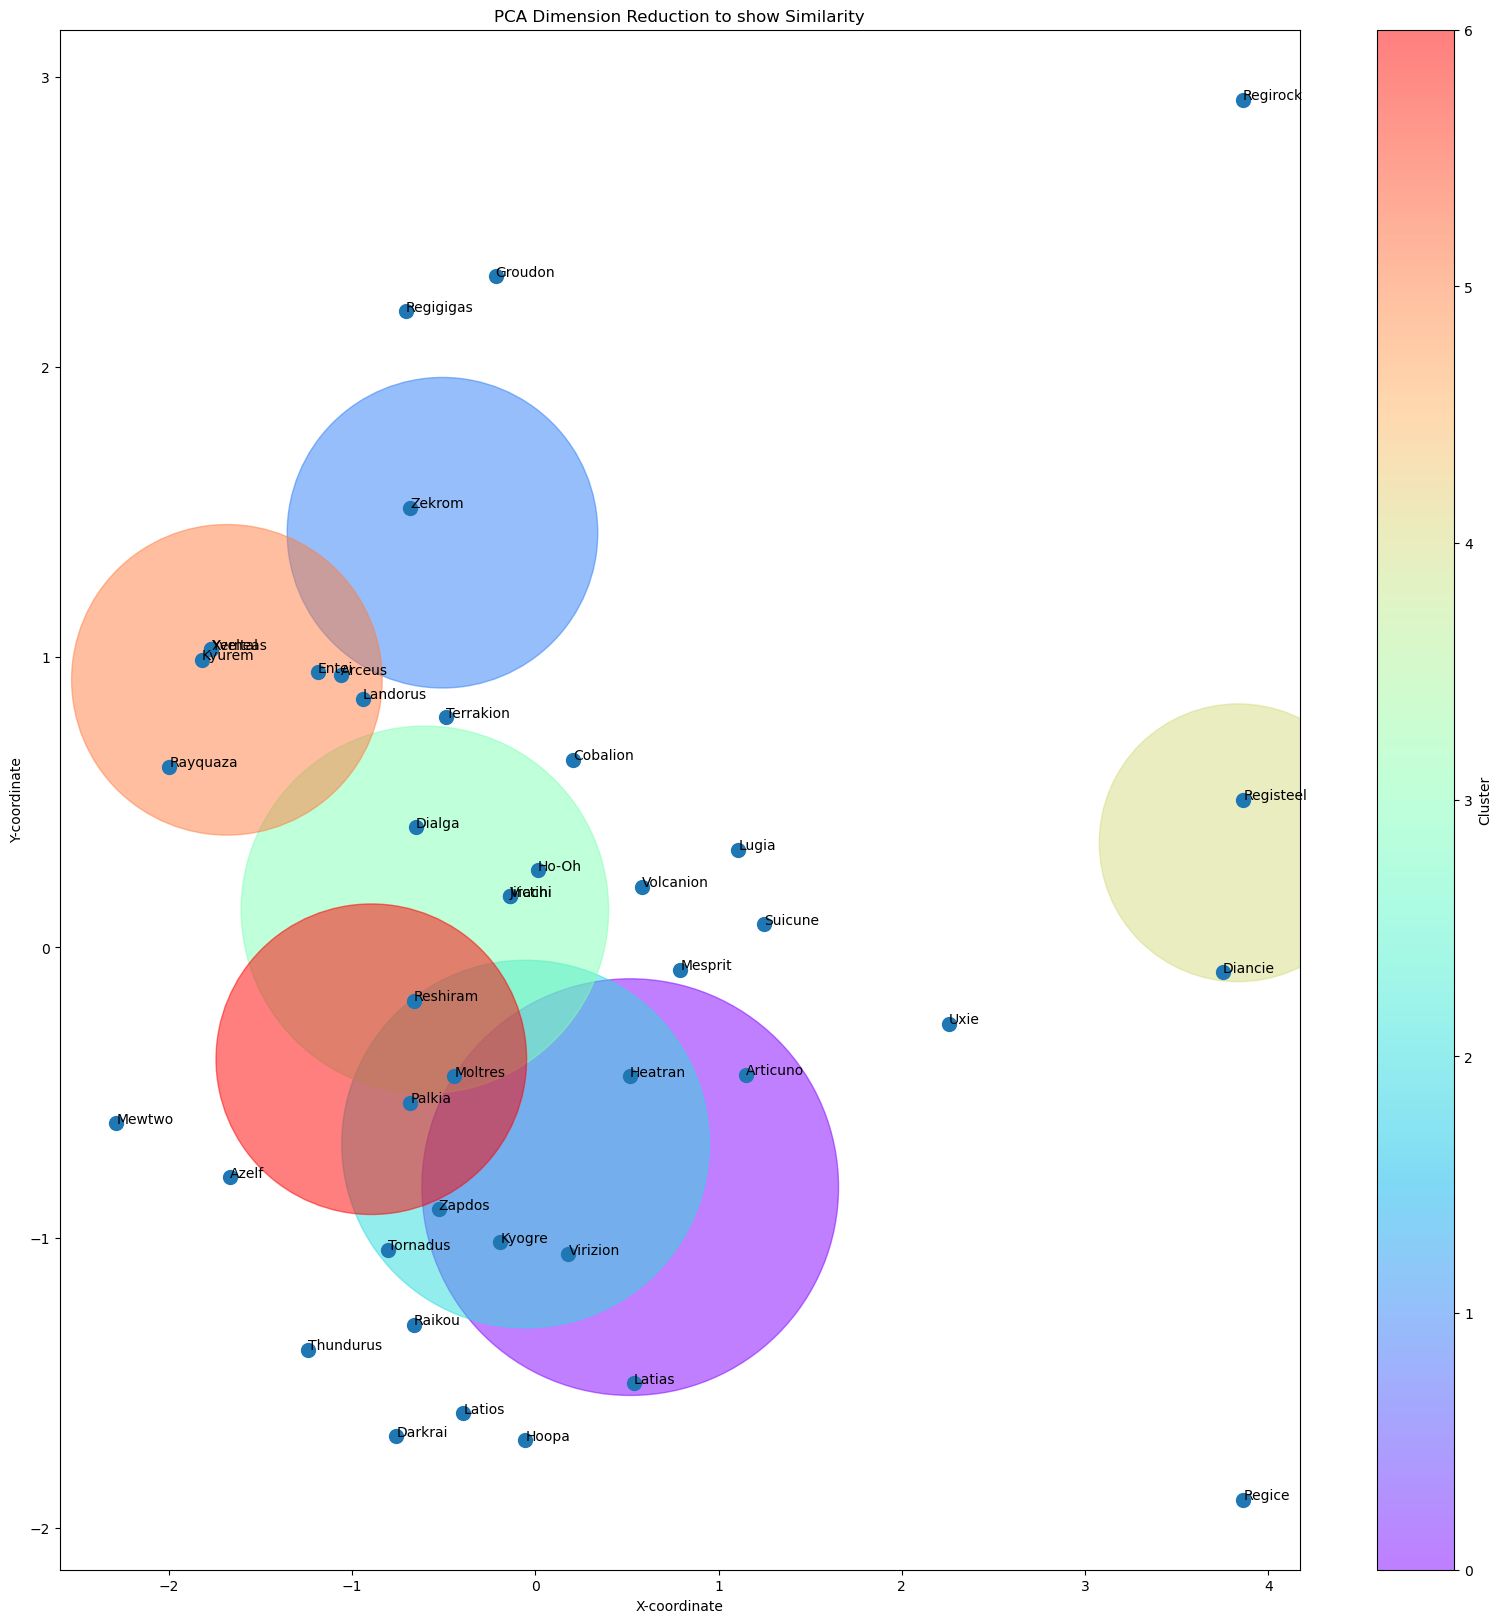

In [53]:
combined = clusters_df.join(tablePCA)
combined
combined['Size'] = combined['Size'].map(lambda s: 10000*s)
ax = combined.plot.scatter('X', 'Y', figsize=(20,20), c='Cluster', s=combined['Size'], alpha=0.5, colormap=plt.cm.rainbow)


pca_df.plot.scatter('X', 'Y', figsize=(20,20), s=100, ax=ax)
for i,r in pca_df.iterrows():
    ax.text(r['X'], r['Y'], pca_df.loc[i, 'Name'])
    
# Labels for the scatter plot
ax.set_xlabel('X-coordinate')
ax.set_ylabel('Y-coordinate')
ax.set_title('PCA Dimension Reduction to show Similarity')

Now that we have points we can graph it.

In conclusion, through the addition of clustering, we are able to group together pokemon with similar attributes.